In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats
from scipy.stats import f_oneway, ttest_ind
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv("/content/Advanced_IoT_Dataset.csv")

In [3]:
# Clean and shorten column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
column_rename_dict = {
    'Random': 'Rand',
    'Average__of_chlorophyll_in_the_plant_ACHP': 'ACHP',
    'Plant_height_rate_PHR': 'PHR',
    'Average_wet_weight_of_the_growth_vegetative_AWWGV': 'AWWGV',
    'Average_leaf_area_of_the_plant_ALAP': 'ALAP',
    'Average_number_of_plant_leaves_ANPL': 'ANPL',
    'Average_root_diameter_ARD': 'ARD',
    'Average_dry_weight_of_the_root_ADWR': 'ADWR',
    'Percentage_of_dry_matter_for_vegetative_growth_PDMVG': 'PDMVG',
    'Average_root_length_ARL': 'ARL',
    'Average_wet_weight_of_the_root_AWWR': 'AWWR',
    'Average_dry_weight_of_vegetative_plants_ADWV': 'ADWV',
    'Percentage_of_dry_matter_for_root_growth_PDMRG': 'PDMRG',
    'Class': 'Class'
}
df.rename(columns=column_rename_dict, inplace=True)

In [4]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rand    30000 non-null  object 
 1   ACHP    30000 non-null  float64
 2   PHR     30000 non-null  float64
 3   AWWGV   30000 non-null  float64
 4   ALAP    30000 non-null  float64
 5   ANPL    30000 non-null  float64
 6   ARD     30000 non-null  float64
 7   ADWR    30000 non-null  float64
 8   PDMVG   30000 non-null  float64
 9   ARL     30000 non-null  float64
 10  AWWR    30000 non-null  float64
 11  ADWV    30000 non-null  float64
 12  PDMRG   30000 non-null  float64
 13  Class   30000 non-null  object 
dtypes: float64(12), object(2)
memory usage: 3.2+ MB


In [5]:
# Descriptive analysis
descriptive_stats = df.describe().T
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
ACHP,30000.0,38.060575,4.441682,32.664004,34.399604,36.575753,42.300836,46.431668
PHR,30000.0,59.020331,11.985213,37.020398,51.059436,55.912058,67.069465,77.040610
AWWGV,30000.0,1.247257,0.245989,0.848351,1.064865,1.211328,1.501692,1.775383
ALAP,30000.0,1063.639833,260.712823,658.488225,875.501356,1009.249081,1243.866525,1751.031654
ANPL,30000.0,3.944789,0.702537,2.959173,3.013099,3.998577,4.015829,5.037358
ARD,30000.0,16.285792,2.882793,11.075737,13.933350,16.248496,18.202577,23.325870
ADWR,30000.0,1.000981,0.456292,0.241972,0.675892,0.833799,1.313504,2.196556
PDMVG,30000.0,22.674553,9.571091,8.021505,14.980983,21.954006,27.711471,43.660373
ARL,30000.0,18.071061,2.932830,12.359924,15.600294,18.477019,20.365252,23.253049
AWWR,30000.0,2.907011,1.361928,1.126715,1.911408,2.818611,3.254133,6.908923


In [6]:
df.isnull().sum()

,0
Rand,0
ACHP,0
PHR,0
AWWGV,0
ALAP,0
ANPL,0
ARD,0
ADWR,0
PDMVG,0
ARL,0


In [7]:
df.duplicated().sum()

0

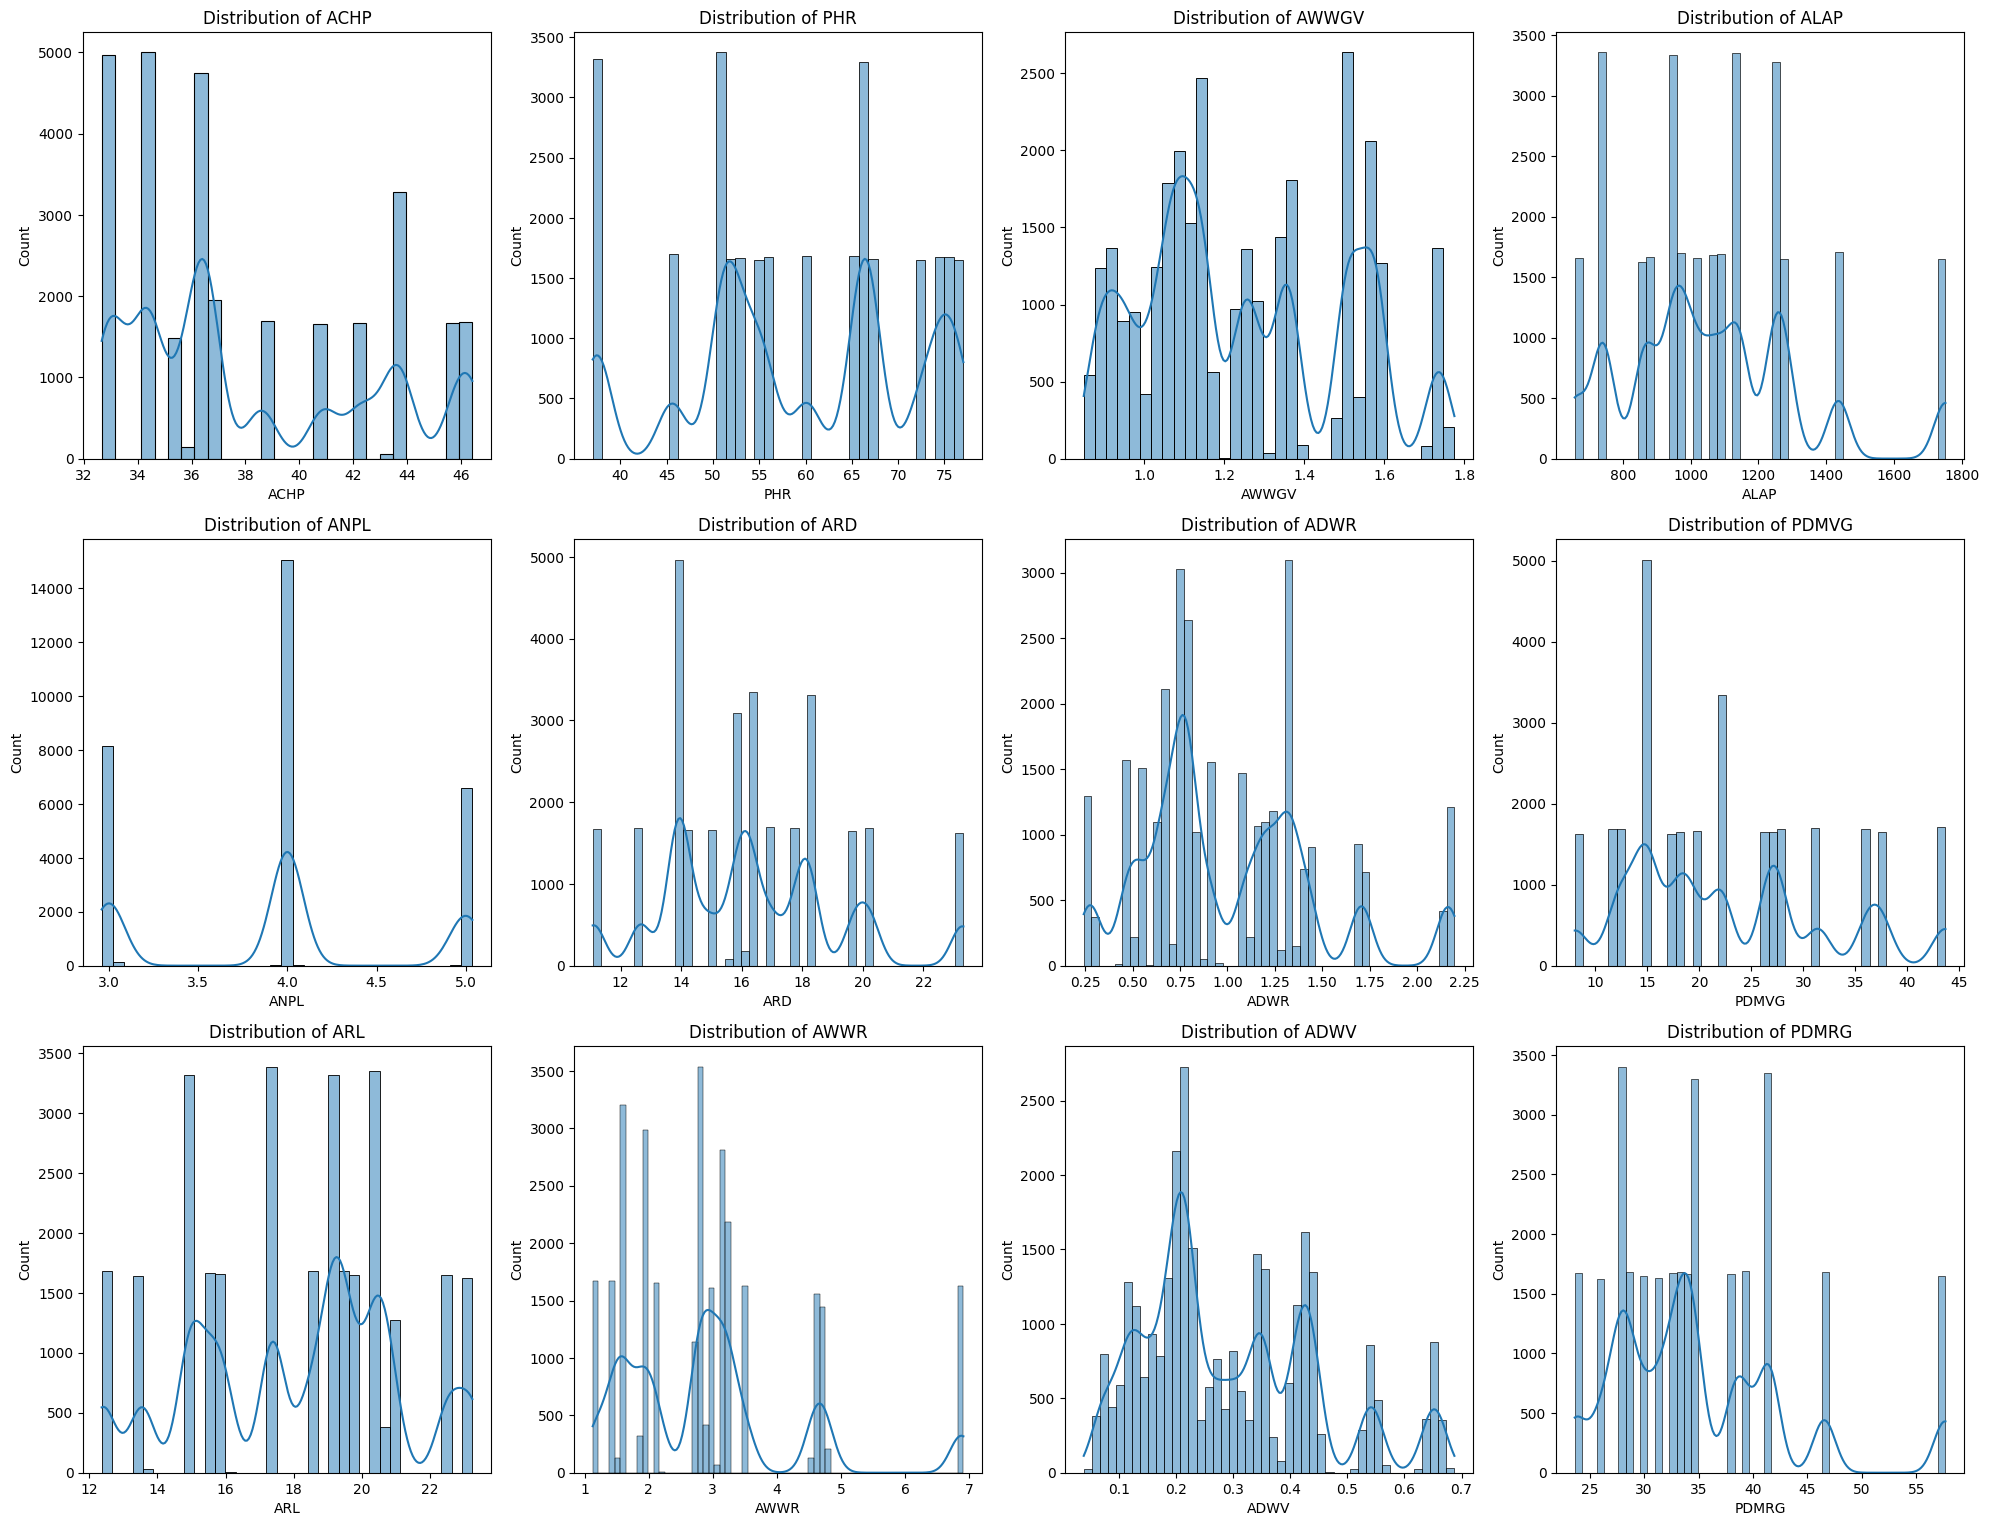

In [8]:
# Draw distribution of each column using subplots
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()
num_plots = len(num_columns)

plt.figure(figsize=(20, 20))
for i, col in enumerate(num_columns):
    plt.subplot((num_plots // 4) + 1, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [9]:
# Check which columns are not normally distributed using Shapiro-Wilk test
non_normal_cols = []
for column in df.columns[1:-1]:  # excluding 'Rand' and 'Class'
    stat, p = stats.shapiro(df[column])
    if p < 0.05:  # p-value < 0.05 indicates non-normal distribution
        non_normal_cols.append(column)

print("Non-normally distributed columns:", non_normal_cols)

Non-normally distributed columns: ['ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD', 'ADWR', 'PDMVG', 'ARL', 'AWWR', 'ADWV', 'PDMRG']


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30000.
  res = hypotest_fun_out(*samples, **kwds)


In [10]:
# Apply transformer (Yeo-Johnson) to normalize non-normally distributed columns
pt = PowerTransformer(method='yeo-johnson')
df[non_normal_cols] = pt.fit_transform(df[non_normal_cols])

In [12]:
# Apply transformer (Yeo-Johnson) to normalize non-normally distributed columns
pt = PowerTransformer(method='yeo-johnson')
df[non_normal_cols] = pt.fit_transform(df[non_normal_cols])

# Check which columns are still not normally distributed after Yeo-Johnson transformation
still_non_normal_cols = []
for column in non_normal_cols:  # Check only the previously non-normal columns
    stat, p = stats.shapiro(df[column])
    if p < 0.05:
        still_non_normal_cols.append(column)

print("Columns still not normally distributed:", still_non_normal_cols)

# Apply Quantile Transformer to the columns still not normalized
qt = QuantileTransformer(output_distribution='normal')
df[still_non_normal_cols] = qt.fit_transform(df[still_non_normal_cols])

Columns still not normally distributed: ['ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD', 'ADWR', 'PDMVG', 'ARL', 'AWWR', 'ADWV', 'PDMRG']


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30000.
  res = hypotest_fun_out(*samples, **kwds)


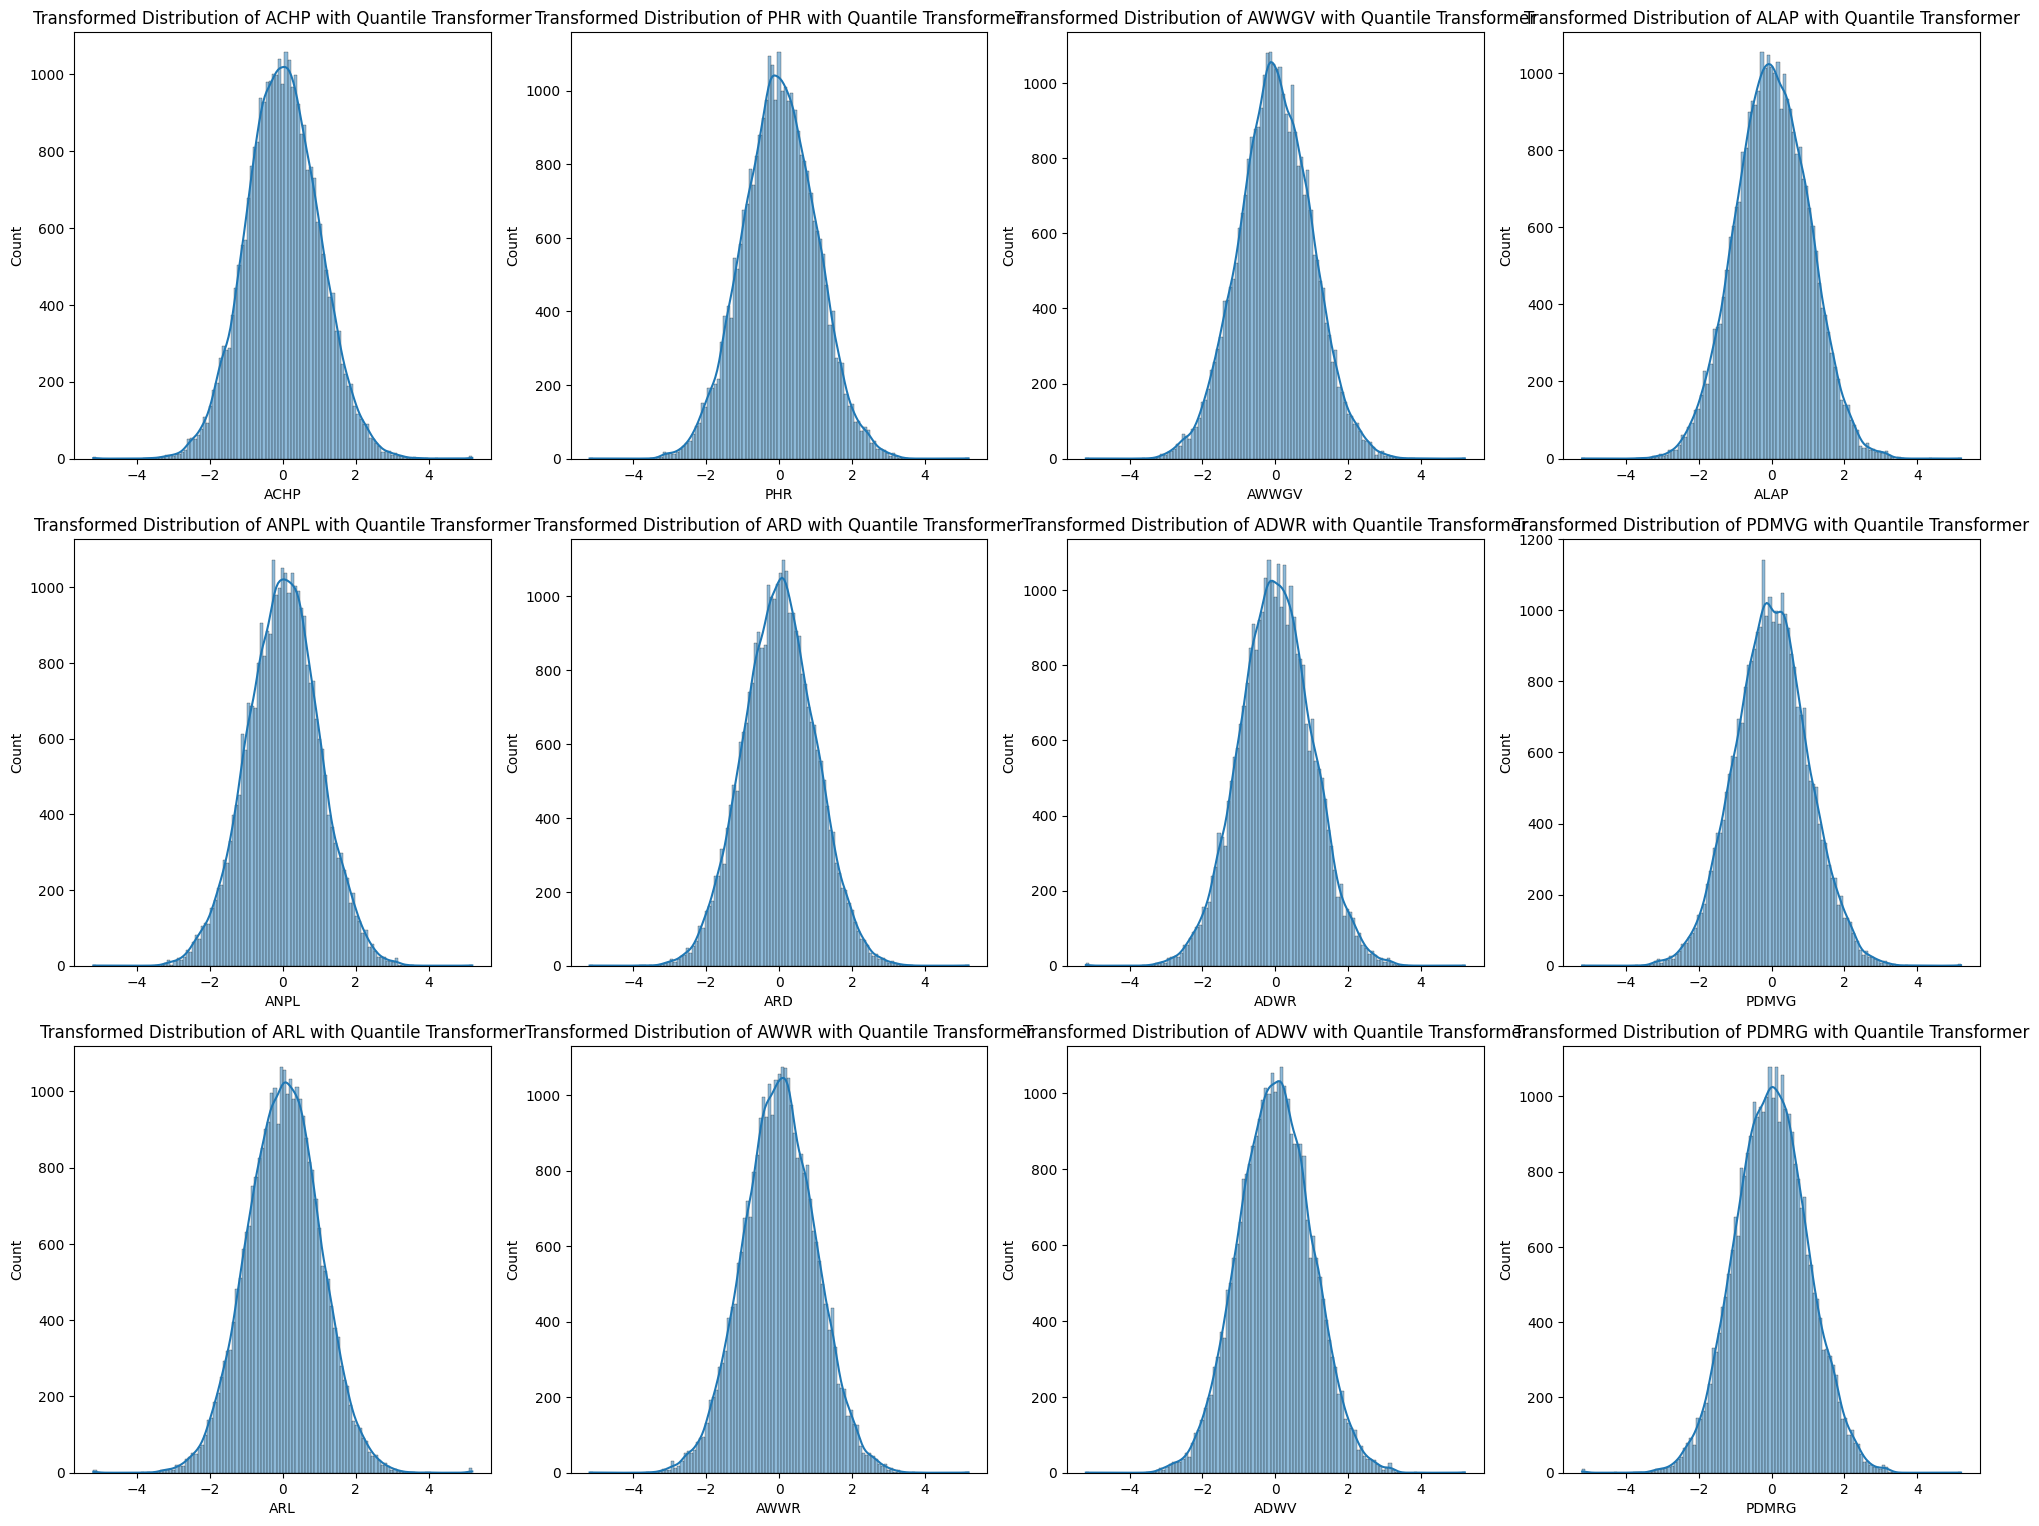

In [13]:
# Verify normalization by plotting again and re-checking with Shapiro-Wilk test
plt.figure(figsize=(20, 20))
for i, col in enumerate(still_non_normal_cols):
    plt.subplot((num_plots // 4) + 1, 4, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Transformed Distribution of {col} with Quantile Transformer')
plt.tight_layout()
plt.show()

In [14]:
# Re-check normalization using Shapiro-Wilk test after Quantile Transformation
final_non_normal_cols = []
for column in still_non_normal_cols:
    stat, p = stats.shapiro(df[column])
    if p < 0.05:  # p-value < 0.05 indicates non-normal distribution
        final_non_normal_cols.append(column)

print("Columns still non-normally distributed after Quantile transformation:", final_non_normal_cols)

Columns still non-normally distributed after Quantile transformation: ['ACHP', 'PHR', 'AWWGV', 'ALAP', 'ANPL', 'ARD', 'ADWR', 'PDMVG', 'ARL', 'AWWR', 'ADWV', 'PDMRG']


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30000.
  res = hypotest_fun_out(*samples, **kwds)


In [15]:
# Plotting descriptive statistics
fig = make_subplots(rows=1, cols=2, subplot_titles=("Mean of Each Feature", "Standard Deviation of Each Feature"))

fig.add_trace(go.Bar(x=descriptive_stats.index, y=descriptive_stats['mean'], name='Mean'), row=1, col=1)
fig.add_trace(go.Bar(x=descriptive_stats.index, y=descriptive_stats['std'], name='Std Dev'), row=1, col=2)

fig.update_layout(title_text="Descriptive Statistics", showlegend=False)
fig.show()

In [16]:
# Detailed statistical analysis using scipy
stat_analysis = {}
for column in df.columns[1:-1]:  # excluding 'Rand' and 'Class'
    stat_analysis[column] = {
        'Shapiro': stats.shapiro(df[column]),
        'Kurtosis': stats.kurtosis(df[column]),
        'Skewness': stats.skew(df[column])
    }

stat_analysis_df = pd.DataFrame(stat_analysis).T
stat_analysis_df

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30000.



,Shapiro,Kurtosis,Skewness
ACHP,"(0.9990398760642619, 4.869368191257119e-12)",0.227677,0.050817
PHR,"(0.99976425756658, 0.0015765492390718986)",-0.002233,0.002755
AWWGV,"(0.9997323257071075, 0.0004810527729517476)",0.0465,-0.005284
ALAP,"(0.9997891210105143, 0.004069869314370882)",-0.047608,0.015806
ANPL,"(0.9996599351011336, 3.7638924560729274e-05)",0.04421,-0.019718
ARD,"(0.9998043382372728, 0.007334217789519831)",-0.004663,0.015764
ADWR,"(0.9994747387055749, 1.2796206505582608e-07)",0.131972,-0.012332
PDMVG,"(0.999644064458699, 2.2108390640000293e-05)",0.068989,0.018859
ARL,"(0.9982550079418064, 1.4368482288679218e-17)",0.340211,-0.013362
AWWR,"(0.9996886505405973, 0.00010096074253856402)",0.075175,-0.005138


In [17]:
# ANOVA and t-tests for detailed analysis
columns_to_analyze = ["ACHP", "PHR", "AWWGV", "ALAP"]

anova_results = f_oneway(*(df[col] for col in columns_to_analyze))
print("ANOVA Results:\n", anova_results)

ANOVA Results:
 F_onewayResult(statistic=2.6839309943732386, pvalue=0.044958120853089034)


In [18]:
# Plotting statistical analysis results
fig = make_subplots(rows=1, cols=3, subplot_titles=("Shapiro P-Values", "Kurtosis", "Skewness"))

fig.add_trace(go.Bar(x=stat_analysis_df.index, y=stat_analysis_df['Shapiro'].apply(lambda x: x[1]), name='Shapiro P-Value'), row=1, col=1)
fig.add_trace(go.Bar(x=stat_analysis_df.index, y=stat_analysis_df['Kurtosis'], name='Kurtosis'), row=1, col=2)
fig.add_trace(go.Bar(x=stat_analysis_df.index, y=stat_analysis_df['Skewness'], name='Skewness'), row=1, col=3)

fig.update_layout(title_text="Detailed Statistical Analysis", showlegend=False)
fig.show()

In [19]:
# ANOVA and t-tests for detailed analysis
columns_to_analyze = ["ACHP", "PHR", "AWWGV", "ALAP"]

anova_results = f_oneway(*(df[col] for col in columns_to_analyze))
ttest_results = {}
for col1 in columns_to_analyze:
    for col2 in columns_to_analyze:
        if col1 != col2:
            ttest_results[f'{col1} vs {col2}'] = ttest_ind(df[col1], df[col2])

ttest_results_df = pd.DataFrame(ttest_results, index=['Statistic', 'p-value']).T
anova_df = pd.DataFrame({"Statistic": [anova_results.statistic], "p-value": [anova_results.pvalue]})

In [20]:
# Displaying detailed statistical analysis
fig = go.Figure(data=[go.Table(
    header=dict(values=["Feature"] + list(stat_analysis_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[stat_analysis_df.index] + [stat_analysis_df[col] for col in stat_analysis_df.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title="Detailed Statistical Analysis")
fig.show()

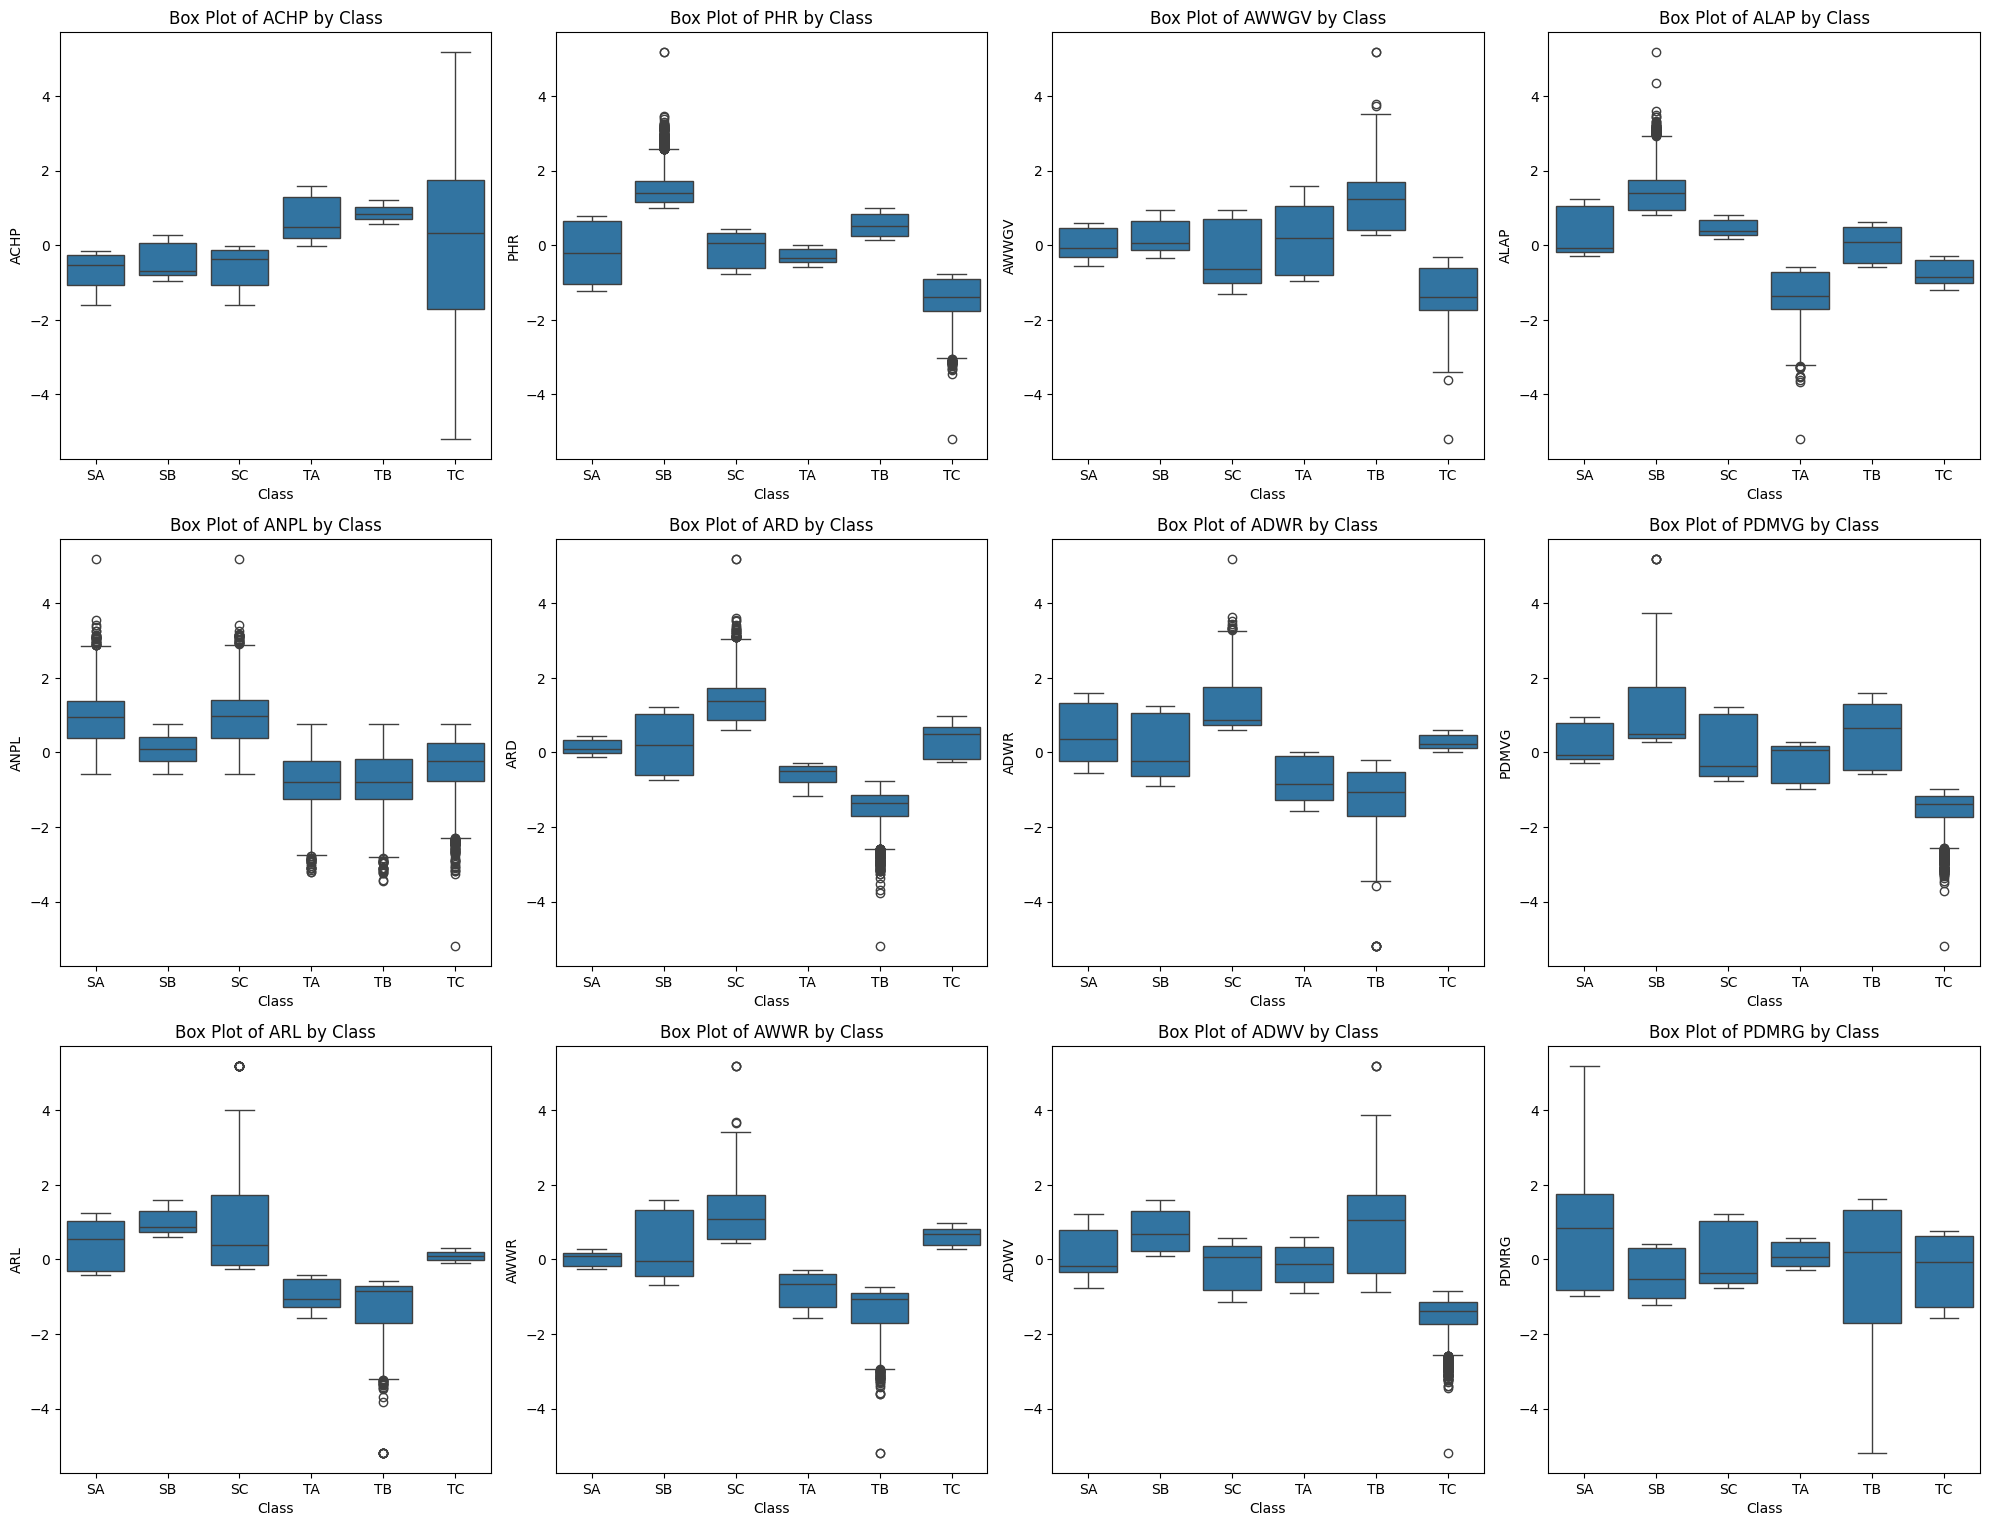

In [21]:
# Box plots for each feature in a single figure
plt.figure(figsize=(20, 20))
for i, col in enumerate(df.columns[1:-1]):
    plt.subplot((len(df.columns[1:-1]) // 4) + 1, 4, i + 1)
    sns.boxplot(x='Class', y=col, data=df)
    plt.title(f'Box Plot of {col} by Class')
plt.tight_layout()
plt.show()

In [22]:
# Correlation heatmap
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
fig = px.imshow(correlation_matrix, text_auto=True, title="Correlation Heatmap", width=1000, height=1000)
fig.show()

In [23]:
# Data preprocessing
df.drop('Rand', axis=1, inplace=True)

In [24]:
# Label encoding for the 'Class' column
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [25]:
# Splitting the dataset
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Hyperparameter tuning - Reduced search space and cross-validation folds
param_grid = {
    'n_estimators': [100, 200],  # Reduced number of estimators
    'max_depth': [None, 10, 20],  # Reduced max_depth options
    'min_samples_split': [2, 5],  # Reduced min_samples_split options
    'min_samples_leaf': [1, 2]  # Reduced min_samples_leaf options
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, n_jobs=-1, verbose=2) # Reduced cv folds to 2
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [30]:
# Best model from Grid Search
best_model = grid_search.best_estimator_

In [31]:
# Model evaluation
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion Matrix:
 [[ 978    0    0    0    0    0]
 [   0 1024    0    0    0    0]
 [   0    0 1046    0    0    0]
 [   0    0    0  950    0    0]
 [   0    0    0    0 1033    0]
 [   0    0    0    0    0  969]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       978
           1       1.00      1.00      1.00      1024
           2       1.00      1.00      1.00      1046
           3       1.00      1.00      1.00       950
           4       1.00      1.00      1.00      1033
           5       1.00      1.00      1.00       969

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [32]:
# Plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = list(le.classes_)
fig = ff.create_annotated_heatmap(z=conf_matrix, x=labels, y=labels, colorscale='Viridis')
fig.update_layout(title="Confusion Matrix", xaxis_title="Predicted Label", yaxis_title="True Label")
fig.show()

In [33]:
# Plotting feature importance
feature_importance = best_model.feature_importances_
features = X.columns
fig = px.bar(x=features, y=feature_importance, title="Feature Importance", labels={'x': 'Feature', 'y': 'Importance'})
fig.show()

In [34]:
# Displaying 10 samples with actual and predicted labels
sample_df = pd.DataFrame(X_test[:10], columns=X.columns)
predictions = y_pred[:10]
actual = y_test[:10].values

results_df = sample_df.copy()
results_df['Actual'] = le.inverse_transform(actual)
results_df['Predicted'] = le.inverse_transform(predictions)

# Display results
fig = go.Figure(data=[go.Table(
    header=dict(values=list(results_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[results_df[col] for col in results_df.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title="Actual vs Predicted Labels for 10 Samples")
fig.show()

In [35]:
# Save output
results_df.to_csv("Advanced_IoT_Predictions_1.csv", index=False)

In [36]:
# Function to input values and get a prediction
def get_prediction(input_data):
    input_df = pd.DataFrame([input_data], columns=X.columns)
    input_scaled = scaler.transform(input_df)
    prediction = best_model.predict(input_scaled)
    predicted_class = le.inverse_transform(prediction)
    return predicted_class[0]

# Example input values
input_values = {
    'ACHP': 34.5,
    'PHR': 54.6,
    'AWWGV': 1.1,
    'ALAP': 1284.2,
    'ANPL': 5.0,
    'ARD': 16.3,
    'ADWR': 1.7,
    'PDMVG': 18.4,
    'ARL': 19.7,
    'AWWR': 2.9,
    'ADWV': 0.2,
    'PDMRG': 57.6
}

# Get prediction
predicted_class = get_prediction(input_values)
print("Predicted Class:", predicted_class)

Predicted Class: SB


In [37]:
# prompt: save the model and give version control

import joblib

# Save the trained model
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

# Optionally, create a version control system (e.g., Git)
# Initialize a Git repository
!git init

# Add the saved model and other relevant files
!git add best_model.pkl scaler.pkl label_encoder.pkl

# Commit the changes
!git commit -m "Initial model commit"

# Create a remote repository (e.g., on GitHub) and push the code
# Replace with your remote repository URL
# !git remote add origin <your_remote_repo_url>
# !git push -u origin main


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@64c735ef2297.(none)')
